* Info source: 2021. July - work in progress
* Use `EXACT` matches not the `MISMATCH1` result.
* Use `_ALL` report files as not all data got averaged in the `_AVERAGE` dataset! Analysis is still going.
* Gene leve summary is calculated not the `sg` level -> what does it mean?

**LOGFC dataset**:

* Represents the most _directly_ interpretable results. LFC: absolute effect size. Effect size is scaled. 
* Scaling:
    * positive (death) controls have LFC of -1
    * negative (no effect) controls have LFC of 0 (and the sd is 1)
    * Any score beyond this range is "of interest" by definition
* Filtering: p <= 0.05 and FDR <= 0.25
* A Note1 or Note2 of *Singletons* indicates that one of the pair is a background control expected to have no effect when edited


**GEMINI dataset**: Gemini scores measure synergistic effects making them less _directly_ interpreatable since one may detect a significant synergistic effect but still find that the combination has a combined LFC within the (-1,0) range making it not obviously of interest as a drug target. On the otherhand, significant synergy leading to a, by definition, unexpected combined LFC outside of the range is of huge interest.

* use the `STRONG_ALL.txt` reports
* we should not use `FDR` for Gemini calls and apply a `p-value` threshold of p <= 0.05

**Suggestion:**

* Emre suggests a table reporting, for each gene,
    1. LFC, 
    2. LFC-p-value, 
    3. LFC-FDR, 
    4. Gemini-score, 
    5. Gemini-p-value, 
    6. Bliss-score, 
    7. Bliss-p-value


In [295]:
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, udf, struct, lit, split, regexp_replace, create_map
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from itertools import chain


# establish spark connection
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '15g')
    .set('spark.executor.memory', '15g')
    .set('spark.driver.maxResultSize', '0')
)
spark = (
    SparkSession.builder
    .config(conf=sparkConf)
    .master('local[*]')
    .getOrCreate()
)

# Mapping tissue annotation of cell lines to UBERON codes:
TISSUE2UBERON = {
    'Large Intestine': 'UBERON_0000059'
}
mapping_tissue = create_map([lit(x) for x in chain(*TISSUE2UBERON.items())])

# Mapping disease label to EFO:
DISEASE2EFO = {
    "Rectal Adenocarcinoma": "EFO_0005631",
    "Colon Carcinoma": "EFO_1001950",
    "Cecum Adenocarcinoma": "EFO_1000020",
    "Colon Adenocarcinoma": "EFO_1001949",
    "Colorectal Carcinoma": "EFO_1001951",
}
mapping_disease = create_map([lit(x) for x in chain(*DISEASE2EFO.items())])



@udf(ArrayType(StructType([
    StructField("targetFromSourceId", StringType(), False),
    StructField("interactingTargetFromSourceId", StringType(), False)
])))
def parse_targets(gene_pair):
    genes = gene_pair.split('~')

    assert(len(genes) == 2)
    parsed = []

    for i, v in enumerate(genes):
        parsed.append({
            'targetFromSourceId': v,
            'interactingTargetFromSourceId': genes[1] if i == 0 else genes[0]
        })

    return parsed


In [146]:
## BRCA-1
# LogFC_file = '/Users/dsuveges/project_data/Shared_Data/OTAR2062/Aug21_AggregatedData/BRCA-1_ExactMatch_LogFC_Cell-Line-Average_All.gene.stats.annotated.txt'
# Gemini_file = '/Users/dsuveges/project_data/Shared_Data/OTAR2062/Aug21_AggregatedData/BRCA-1_ExactMatch_GEMINI_STRONG_ALL.txt'

## COLO-1
LogFC_file = '/Users/dsuveges/project_data/Shared_Data/OTAR2062/Aug21_AggregatedData/COLO-1_ExactMatch_LogFC_Cell-Line-Average_All.gene.stats.annotated.txt'
Gemini_file = '/Users/dsuveges/project_data/Shared_Data/OTAR2062/Aug21_AggregatedData/COLO-1_ExactMatch_GEMINI_STRONG_ALL.txt'


model_list_file = '/Users/dsuveges/project_data/Shared_Data/model_list_20210719.csv'


In [297]:
'''
In the model list dataset a wide set of columns are available, but most columns are irrelevant.
'''             
model_list = (
    spark.read.csv(model_list_file, sep=',', header=True)
    .withColumn('tissueId', mapping_tissue[col("tissue")])
    .withColumnRenamed('cancer_type_detail', 'diseaseFromSource')
    .withColumn(
        'diseaseCellLines', 
        array(struct(
            col('model_id').alias('id'),
            col('model_name').alias('name'),
            col('tissue'),
            col('tissueId')
        ))
    )
    .select('model_id', 'diseaseFromSource', 'diseaseCellLines')
)

print(model_list.count())
print(model_list.show(1, vertical=True, truncate=False))
model_list.printSchema()

2307
-RECORD 0--------------------------------------------------------------
 model_id          | SIDM01274                                         
 diseaseFromSource | Esophageal Adenocarcinoma                         
 diseaseCellLines  | [{SIDM01274, HCM-SANG-0314-C15, Esophagus, null}] 
only showing top 1 row

None
root
 |-- model_id: string (nullable = true)
 |-- diseaseFromSource: string (nullable = true)
 |-- diseaseCellLines: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- id: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- tissue: string (nullable = true)
 |    |    |-- tissueId: string (nullable = true)



In [316]:
## 
## Function to parse and process the log fold change file:
##
def parse_logfc_file(logfc_file):
    '''
    Reads logfc data, parses headers/cell lines and returns a pyspark dataframe
    
    Standard header: SIDM00833_R39603_goodsgrna
    Parsed to: 
        * cell line: "SIDM00833_R39603"
        * field: "goodsgrna"
        
    Schema:
        root
         |-- id: string (nullable = true)
         |-- cellLineName: string (nullable = true)
         |-- phenotypicConsequenceLogFoldChange: float (nullable = true)
         |-- phenotypicConsequencePValue: float (nullable = true)
         |-- phenotypicConsequenceFDR: float (nullable = true)
    '''
    
    # What is in the files:
    df = (
        spark.read.csv(logfc_file, sep=' ', header=True)
    )

    print(f'Number of rows in the logFC dataset: {df.count()}')
    
    columns = df.columns[4:]

    # Parsing the schema to infer cell lines and parameters:
    cell_lines = set('_'.join(x.split('_')[:-1]) for x in columns)
    fields = set(x.split('_')[-1] for x in columns)
    
    print(f'Number of identified cell lines: {len(cell_lines)}')
    print(f'Fields: {",".join(fields)}')

    # Generating "un-pivot" expression:
    unpivot_expression = f'''stack({len(cell_lines)}, {", ".join([f"'{x}', {x}" for x in cell_lines])} ) as (cellLineName, cellLineData)'''

    # Generating expressions to create the full struct object for each cell line:
    expressions = map(lambda cell_line: (cell_line, struct([col(f'{cell_line}_{x}').cast(FloatType()).alias(x) for x in fields])), cell_lines)

    # Applying map on the dataframe:
    res_df = reduce(lambda DF,value: DF.withColumn(*value) , expressions, df)
    
    # Melting the dataset:
    melted_df = (
        res_df
        
        # Unpivot:
        .select('id', 'Note1', 'Note2', expr(unpivot_expression))

        # Applyting p-value and fdr filters following Emre's suggestion:
        .filter((col('cellLineData.p-value') <= 0.05) & (col('cellLineData.fdr') <= 0.25))

        # Extracting the real model id:
        .select(
            'id', 'cellLineName', 
            col('cellLineData.lfc').alias('phenotypicConsequenceLogFoldChange'),
            col('cellLineData.p-value').alias('phenotypicConsequencePValue'),
            col('cellLineData.fdr').alias('phenotypicConsequenceFDR')
        )
        .persist()
    )
    
    # Get results:
    print(f'Number of rows in the filtered melted dataset: {melted_df.count()}')
    print('Schema of the dataset: ')
    print(melted_df.printSchema())
    
    return melted_df


def parse_gemini_file(gemini_file):
    '''
    Reads GEMINI data, parses headers/cell lines and returns a pyspark dataframe
    
    Standard header: SIDM00778_R39704_strong_FDR
    Parsed to: 
        * cell line: "SIDM00778_R39704"
        * field: "FDR"
        
    Schema:
        root
         |-- id: string (nullable = true)
         |-- cellLineName: string (nullable = true)
         |-- geneticInteractionMethod: string (nullable = false)
         |-- geneticInteractionScore: float (nullable = true)
         |-- geneticInteractionPValue: float (nullable = true)
         |-- geneticInteractionFDR: float (nullable = true)
    '''
        # What is in the files:
    df = (
        spark.read.csv(gemini_file, sep=' ', header=True)
    )

    print(f'Number of rows in the GEMINI dataset: {df.count()}')
    
    columns = df.columns[3:]

    # Parsing the schema to infer cell lines and parameters:
    cell_lines = set('_'.join(x.replace('_strong', '').split('_')[:-1]) for x in columns)
    fields = set(x.split('_')[-1] for x in columns)

    print(f'Number of identified cell lines: {len(cell_lines)}')
    print(f'Fields: {",".join(fields)}')

    # Generating "un-pivot" expression:
    unpivot_expression = f'''stack({len(cell_lines)}, {", ".join([f"'{x}', {x}" for x in cell_lines])} ) as (cellLineName, cellLineData)'''

    # Generating expressions to create the full struct object for each cell line:
    expressions = map(lambda cell_line: (cell_line, struct([col(f'{cell_line}_strong_{x}').cast(FloatType()).alias(x) for x in fields])), cell_lines)

    # Applying map on the dataframe:
    res_df = reduce(lambda DF,value: DF.withColumn(*value) , expressions, df)
    
    # Melting the dataset:
    melted_df = (
        res_df

        # Applyting p-value and fdr filters following Emre's suggestion:
        .select('Gene_Pair', expr(unpivot_expression))
        .withColumn('id', regexp_replace(col('Gene_Pair'), ';', '~'))

        # Selecting and renaming columns:
        .select(
            'id', 'cellLineName',
            lit('gemini').alias('geneticInteractionMethod'),
            col('cellLineData.score').alias('geneticInteractionScore'),
            col('cellLineData.pval').alias('geneticInteractionPValue'),
            col('cellLineData.FDR').alias('geneticInteractionFDR')
        )
        .persist()
    )
    
    # Get results:
    print(f'Number of rows in the melted dataset: {melted_df.count()}')
    print('Schema of the dataset: ')
    print(melted_df.printSchema())
    
    return melted_df


lfc_melted = parse_logfc_file(LogFC_file)
gemini_melted_df = parse_gemini_file(Gemini_file)



Number of rows in the logFC dataset: 20334
Number of identified cell lines: 42
Fields: p-value,goodsgrna,fdr,lfc
Number of rows in the filtered melted dataset: 136036
Schema of the dataset: 
root
 |-- id: string (nullable = true)
 |-- cellLineName: string (nullable = true)
 |-- phenotypicConsequenceLogFoldChange: float (nullable = true)
 |-- phenotypicConsequencePValue: float (nullable = true)
 |-- phenotypicConsequenceFDR: float (nullable = true)

None
Number of rows in the GEMINI dataset: 17782
Number of identified cell lines: 35
Fields: FDR,score,pval
Number of rows in the melted dataset: 622370
Schema of the dataset: 
root
 |-- id: string (nullable = true)
 |-- cellLineName: string (nullable = true)
 |-- geneticInteractionMethod: string (nullable = false)
 |-- geneticInteractionScore: float (nullable = true)
 |-- geneticInteractionPValue: float (nullable = true)
 |-- geneticInteractionFDR: float (nullable = true)

None


In [330]:
merged = (
    
    # Merging GEMINI and FLC data into a single dataframe:
    gemini_melted_df
    .join(broadcast(lfc_melted.orderBy(col('id'))), on=['id', 'cellLineName'], how='inner')
    
    # Processing true cell line identifier:
    .withColumn('model_id', split(col('cellLineName'), '_').getItem(0))
    
    # Joining with cell line data:
    .join(model_list, on='model_id', how='left')
    
    # Parsing/exploding gene names:
    .withColumn('id', parse_targets(col('id')))
    .select('*', explode(col('id')).alias('genes'))
    .select('*', col('genes.*'))
    .drop('id', 'genes')
    
    # Adding some literals specific for this type of evidence:
    .withColumn('datatypeId', lit('ot_partner'))
    .withColumn('datasourceId', lit('encore'))
    .withColumn('projectId', lit('OTAR2062'))
    
    # Map disease to efo:
    .withColumn('diseaseFromSourceMappedId', mapping_disease[col('diseaseFromSource')])
    
    # Removing duplications:
    .drop('cellLineName')
    .distinct()
    
    # Renaming columns:
    .withColumnRenamed('model_id', 'cellType')
)

merged.show(1, vertical=True, truncate=False)
merged.printSchema()
merged.count() # 105_354 -> with distinct: 86_616

-RECORD 0----------------------------------------------------------------------------------
 cellType                           | SIDM00049                                            
 geneticInteractionMethod           | gemini                                               
 geneticInteractionScore            | 2.191241                                             
 geneticInteractionPValue           | 7.607547E-4                                          
 geneticInteractionFDR              | 0.031387564                                          
 phenotypicConsequenceLogFoldChange | -2.1679                                              
 phenotypicConsequencePValue        | 0.010476                                             
 phenotypicConsequenceFDR           | 0.129803                                             
 diseaseFromSource                  | Colorectal Carcinoma                                 
 diseaseCellLines                   | [{SIDM00049, DiFi, Large Intestine, UBERON

86616

In [331]:
# Re-order columns and save data:
(
    merged
    .select(
        # General fields:
        'datatypeId', 'datasourceId', 'projectId',
        
        # Target related fields:
        'targetFromSourceId', 'interactingTargetFromSourceId',
        
        # Disease related fields:
        'diseaseFromSource', 'diseaseFromSourceMappedId',
        
        # Cell related fields:
        'diseaseCellLines', 'cellType',
        
        # CRISPR related fields:
        'phenotypicConsequenceLogFoldChange', 'phenotypicConsequenceFDR', 'phenotypicConsequencePValue',
        'geneticInteractionMethod', 'geneticInteractionScore', 'geneticInteractionPValue', 'geneticInteractionFDR'
    )
    .coalesce(1)
#     .printSchema()
    .write.format('json').mode('overwrite').option('compression', 'gzip')
    .save('encore_test_2021-10-20')
)

<AxesSubplot:>

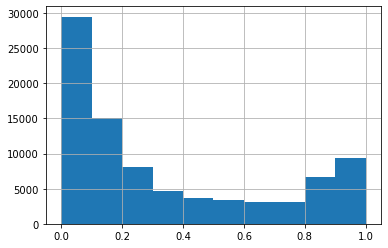

In [335]:
merged.select('geneticInteractionPValue').toPandas().geneticInteractionPValue.hist()

In [1]:
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, udf, struct, lit, split, regexp_replace, create_map
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from itertools import chain


# establish spark connection
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '15g')
    .set('spark.executor.memory', '15g')
    .set('spark.driver.maxResultSize', '0')
)
spark = (
    SparkSession.builder
    .config(conf=sparkConf)
    .master('local[*]')
    .getOrCreate()
)




In [2]:
df = (spark.read.json('encore_test_2021-10-20')).persist()

In [3]:
df.count()

86616

In [4]:
df.printSchema()

root
 |-- cellType: string (nullable = true)
 |-- datasourceId: string (nullable = true)
 |-- datatypeId: string (nullable = true)
 |-- diseaseCellLines: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- tissue: string (nullable = true)
 |    |    |-- tissueId: string (nullable = true)
 |-- diseaseFromSource: string (nullable = true)
 |-- diseaseFromSourceMappedId: string (nullable = true)
 |-- geneticInteractionFDR: double (nullable = true)
 |-- geneticInteractionMethod: string (nullable = true)
 |-- geneticInteractionPValue: double (nullable = true)
 |-- geneticInteractionScore: double (nullable = true)
 |-- interactingTargetFromSourceId: string (nullable = true)
 |-- phenotypicConsequenceFDR: double (nullable = true)
 |-- phenotypicConsequenceLogFoldChange: double (nullable = true)
 |-- phenotypicConsequencePValue: double (nullable = true)
 |-- projectId: st

In [3]:
print('''query CrisprQuery($ensemblId: String!, $efoId: String!, $size: Int!) {\n  disease(efoId: $efoId) {\n    id\n    evidences(ensemblIds: [$ensemblId], enableIndirect: true, datasourceIds: [\"crispr\"], size: $size) {\n      rows {\n        disease {\n          id\n          name\n          __typename\n        }\n        diseaseCellLines\n        diseaseFromSource\n        resourceScore\n        literature\n        __typename\n      }\n      __typename\n    }\n    __typename\n  }\n}\n"''')

query CrisprQuery($ensemblId: String!, $efoId: String!, $size: Int!) {
  disease(efoId: $efoId) {
    id
    evidences(ensemblIds: [$ensemblId], enableIndirect: true, datasourceIds: ["crispr"], size: $size) {
      rows {
        disease {
          id
          name
          __typename
        }
        diseaseCellLines
        diseaseFromSource
        resourceScore
        literature
        __typename
      }
      __typename
    }
    __typename
  }
}
"


In [4]:
length = 7
string = ' ' * length


'       '